In [1]:
# let's plot the probability of beaching globally

In [2]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [3]:
# dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tqdm import tqdm

import scipy.interpolate as sci_int
import scipy.stats as sci_stats
import geopandas as gpd

from scipy.ndimage import gaussian_filter,  generic_filter

In [4]:
# set plotting text size parameters
plt.rcParams.update({
    'axes.titlesize': 30,
    'axes.labelsize': 24, 
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 18, 
    'figure.titlesize': 28})

In [5]:
# load probability of beaching data
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

In [6]:
os.chdir('/home/openonic/global-drifter-program/')

In [7]:
# we follow the steps in the probability of beaching notebook:
# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

In [8]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

In [9]:
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

In [10]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued)#.iloc[30:-30]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [11]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued)#.iloc[30:-30]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [18]:
def nan_gaussian_filter(values, sigma):
    mask = np.isnan(values)
    values_filled = np.where(mask, np.nanmean(values), values)  # Replace NaNs with the mean of non-NaNs
    filtered = gaussian_filter(values_filled, sigma=sigma)
    filtered[mask] = np.nan  # Restore NaNs
    return filtered

# Apply the custom Gaussian filter
beach_prob_vals_filtered = nan_gaussian_filter(beach_prob_vals, sigma=0.5)

In [19]:
# define desired rows and desired cols
desired_rows = 360
desired_cols = 180
# define lat and lon
lats = np.linspace(-90,90,desired_cols)
lons = np.linspace(-180, 180, desired_rows)

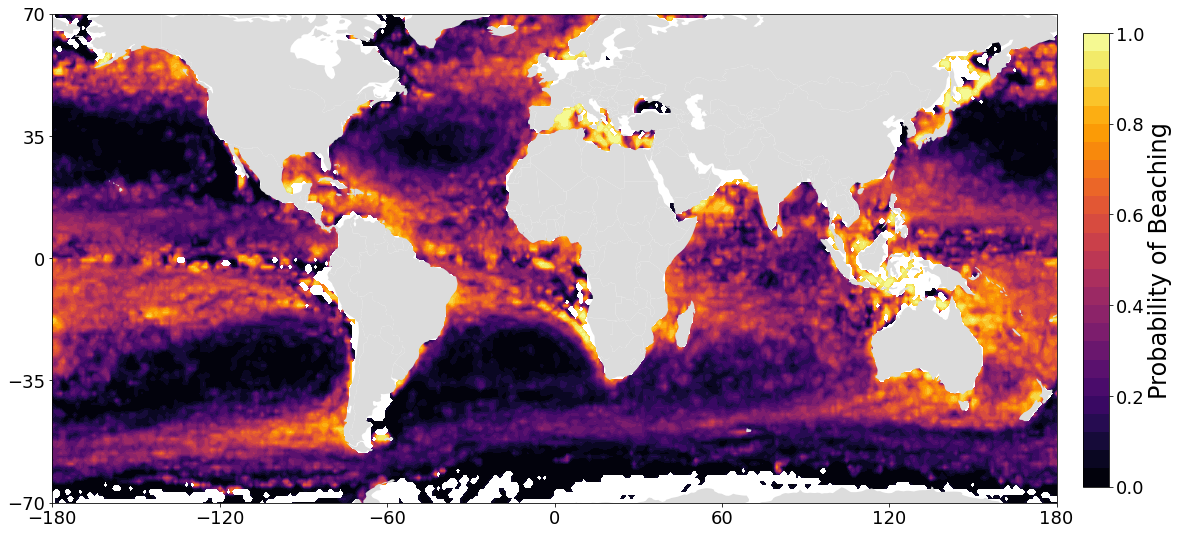

In [22]:
# Load world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']


# visualize probability of beaching
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 9),
                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180])
ax1.set_yticks([-70, -35, 0, 35, 70])


cmap = plt.get_cmap('inferno').copy()
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, beach_prob_vals_filtered, cmap=cmap, transform=ccrs.PlateCarree(), 
                   vmin=0, vmax=1.0, levels = 24)


#ax1.set_title('Probability of Beaching')
#ax1.set_xlabel('Longitude')
#ax1.set_ylabel('Latitude')

land.plot(ax=ax1, color='gainsboro', edgecolor='none')
Antarctica.plot(ax=ax1, color='gainsboro', edgecolor='none')
ax1.set_aspect('auto')

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, label='Probability of Beaching')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
im1.set_clim(0, 1.0)  # This sets the color limits for the ScalarMappable

#plt.savefig('probability_of_beaching.png', dpi=300)

# Show the plot
plt.show()